# Classification Of Fundus Images
## The Dataset Contains over 3200 Images related 46 fundus diseases distributed into three sets train,evaluation, test.
### Computer vision has plethora of applications in the area medical imaging aim of this project is to identify and classify the fundus disease from retina imaging.According to the WHO, World report on vision 2019, the number of visually impaired people worldwide is estimated to be 2.2 billion, of whom at least 1 billion have a vision impairment that could have been prevented or is yet to be addressed. The world faces considerable challenges in terms of eye care, including inequalities in the coverage and quality of prevention, treatment, and rehabilitation services. Early detection and diagnosis of ocular pathologies would enable forestall of visual impairment.To give insights of models decision we require apply XAI techniques which could be helpful for doctors whether trust the decision of model or not.

[link to dataset](https://www.kaggle.com/andrewmvd/retinal-disease-classification)

In [1]:
import modin.pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
import cv2
from skimage.color import rgb2gray
os.environ["MODIN_ENGINE"] = "ray"
import ray
ray.init()


2021-09-08 06:26:55,452	INFO services.py:1263 -- View the Ray dashboard at http://127.0.0.1:8265


{'node_ip_address': '192.168.0.100',
 'raylet_ip_address': '192.168.0.100',
 'redis_address': '192.168.0.100:6379',
 'object_store_address': '/tmp/ray/session_2021-09-08_06-26-53_879689_5582/sockets/plasma_store',
 'raylet_socket_name': '/tmp/ray/session_2021-09-08_06-26-53_879689_5582/sockets/raylet',
 'webui_url': '127.0.0.1:8265',
 'session_dir': '/tmp/ray/session_2021-09-08_06-26-53_879689_5582',
 'metrics_export_port': 61430,
 'node_id': '06d04222df84413c52379d52cd60396bc46220dc7be99854d8c41c4a'}

In [2]:
import tensorflow as tf
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
%matplotlib inline

In [3]:
import skmultilearn
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import MultinomialNB, GaussianNB
from sklearn.ensemble import RandomForestClassifier
from skmultilearn.problem_transform import BinaryRelevance
from skmultilearn.problem_transform import ClassifierChain
from skmultilearn.problem_transform import LabelPowerset
from skmultilearn.adapt import MLkNN


## Importing Data

In [4]:
dftrain = pd.read_csv('input/Training_Set/RFMiD_Training_Labels.csv')
dftest = pd.read_csv('input/Test_Set/Test_Set/RFMiD_Testing_Labels.csv')
dfeval = pd.read_csv(
    'input/Evaluation_Set/Evaluation_Set/RFMiD_Validation_Labels.csv')


In [5]:
print(dftrain.shape)
print(dftest.shape)
print(dfeval.shape)


(1920, 47)
(640, 47)
(640, 47)


## Visualization Of Original Image

Text(0.5, 1.0, 'Image from Test Set')

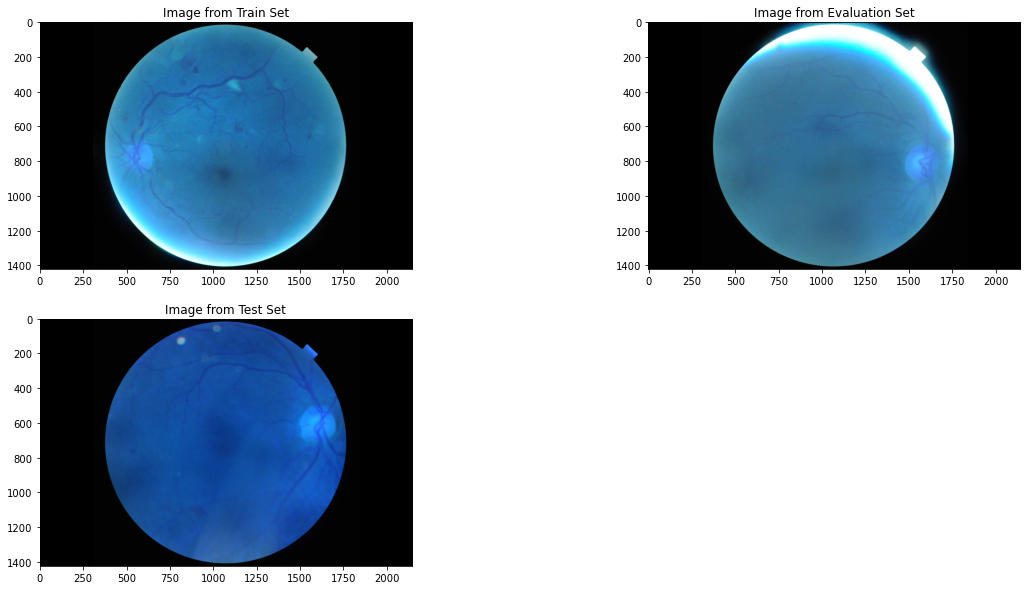

In [6]:
img1 = cv2.imread(f'input/Training_Set/Training/{dftrain["ID"][100]}.png')
img2 = cv2.imread(
    f'input/Evaluation_Set/Evaluation_Set/Validation/{dfeval["ID"][100]}.png')
img3 = cv2.imread(f'input/Test_Set/Test_Set/Test/{dftest["ID"][100]}.png')
fig = plt.figure(figsize=(20, 10))
fig.add_subplot(2, 2, 1)
plt.imshow(img1)
plt.title("Image from Train Set")
fig.add_subplot(2, 2, 2)
plt.imshow(img2)
plt.title("Image from Evaluation Set")
fig.add_subplot(2, 2, 3)
plt.imshow(img3)
plt.title("Image from Test Set")

## Checking The Size Of Original Images

In [7]:
height, width = img2.shape[:2]
print(height)
print(width)

1424
2144


## Resizing The Image to 256 * 256

In [8]:
img1 = cv2.resize(img1,(256,256))
img2 = cv2.resize(img2, (256, 256))
img3 = cv2.resize(img3, (256, 256))
height, width = img1.shape[:2]
print(height)
print(width)


256
256


## Plotting The Resized Images

Text(0.5, 1.0, 'Image from Test Set')

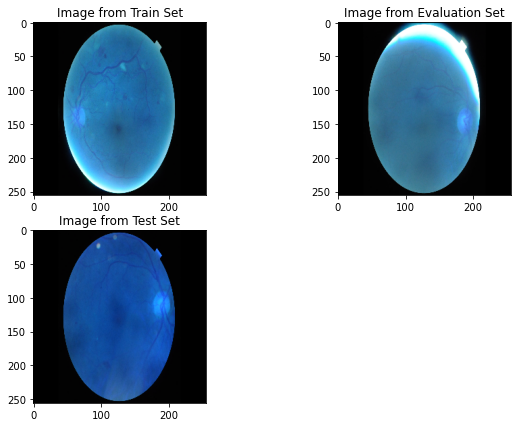

In [9]:
fig = plt.figure(figsize=(10, 7))
fig.add_subplot(2, 2, 1)
plt.imshow(img1)
plt.title("Image from Train Set")
fig.add_subplot(2, 2, 2)
plt.imshow(img2)
plt.title("Image from Evaluation Set")
fig.add_subplot(2, 2, 3)
plt.imshow(img3)
plt.title("Image from Test Set")

## Data Distribution In Train Set.

In [10]:
z = dftrain["Disease_Risk"].value_counts()
trainStats = pd.DataFrame({"name":[z.name],"0":[z[0]],"1":[z[1]]})
for x in dftrain.columns[2:]:
    val = dftrain[x].value_counts()
    if(val.size==2):
        temp = pd.DataFrame({"name": [val.name], "0": [val[0]], "1": [val[1]]})
        trainStats = trainStats.append(temp,ignore_index=True)
    if(val.size==1):
        if(dftrain[x][0]==0):
            temp = pd.DataFrame(
                {"name": [val.name], "0": [val[0]], "1": [0]})
            trainStats = trainStats.append(temp,ignore_index=True)
        else:
            temp = pd.DataFrame(
                {"name": [val.name], "0": [0], "1": [val[1]]})
            trainStats = trainStats.append(temp,ignore_index=True)
trainStats

To request implementation, send an email to feature_requests@modin.org.


,name,0,1
0,Disease_Risk,401,1519
1,DR,1544,376
2,ARMD,1820,100
3,MH,1603,317
4,DN,1782,138
5,MYA,1819,101
6,BRVO,1847,73
7,TSLN,1734,186
8,ERM,1906,14
9,LS,1873,47


In [11]:
z = dfeval["MCA"].value_counts(sort=True)
z[0]

640

## Data Distributiion in Evaluation Set.

In [12]:
z = dfeval["Disease_Risk"].value_counts()
evalStats = pd.DataFrame({"name": [z.name], "0": [z[0]], "1": [z[1]]})
for x in dfeval.columns[2:]:
    val = dfeval[x].value_counts()
    if(val.size == 2):
        temp = pd.DataFrame({"name": [val.name], "0": [val[0]], "1": [val[1]]})
        evalStats = evalStats.append(temp, ignore_index=True)
    if(val.size == 1):
        if(dfeval[x][0] == 0):
            temp = pd.DataFrame(
                {"name": [val.name], "0": [val[0]], "1": [0]})
            evalStats = evalStats.append(temp, ignore_index=True)
        else:
            temp = pd.DataFrame(
            {"name": [val.name], "0": [0], "1": [val[1]]})
            evalStats = evalStats.append(temp, ignore_index=True)
evalStats

,name,0,1
0,Disease_Risk,134,506
1,DR,508,132
2,ARMD,602,38
3,MH,538,102
4,DN,594,46
5,MYA,606,34
6,BRVO,617,23
7,TSLN,575,65
8,ERM,633,7
9,LS,623,17


## Data Distributiion In Test Set.

In [13]:
z = dftest["Disease_Risk"].value_counts()
testStats = pd.DataFrame({"name": [z.name], "0": [z[0]], "1": [z[1]]})
for x in dftest.columns[2:]:
    val = dftest[x].value_counts()
    if(val.size == 2):
        temp = pd.DataFrame({"name": [val.name], "0": [val[0]], "1": [val[1]]})
        testStats = testStats.append(temp, ignore_index=True)
    if(val.size == 1):
        if(dftest[x][0] == 0):
            temp = pd.DataFrame(
                {"name": [val.name], "0": [val[0]], "1": [0]})
            testStats = testStats.append(temp, ignore_index=True)
        else:
            temp = pd.DataFrame(
                {"name": [val.name], "0": [0], "1": [val[1]]})
            testStats = testStats.append(temp, ignore_index=True)
testStats

,name,0,1
0,Disease_Risk,134,506
1,DR,516,124
2,ARMD,609,31
3,MH,536,104
4,DN,594,46
5,MYA,608,32
6,BRVO,617,23
7,TSLN,587,53
8,ERM,635,5
9,LS,625,15


## rgb2gray Conversion For Ease of Computaion.

Text(0.5, 1.0, 'Image from Test Set')

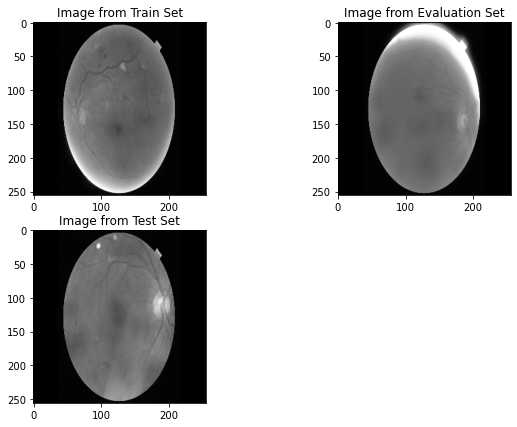

In [14]:

grayscale1 = rgb2gray(img1)
grayscale2 = rgb2gray(img2)
grayscale3 = rgb2gray(img3)
fig = plt.figure(figsize=(10, 7))
fig.add_subplot(2, 2, 1)
plt.imshow(grayscale1, cmap=plt.cm.gray)
plt.title("Image from Train Set")
fig.add_subplot(2, 2, 2)
plt.imshow(grayscale2, cmap=plt.cm.gray)
plt.title("Image from Evaluation Set")
fig.add_subplot(2, 2, 3)
plt.imshow(grayscale3, cmap=plt.cm.gray)
plt.title("Image from Test Set")

## Peek at AMAX and AMIN Values

In [15]:
min = np.amin(grayscale1)
max = np.amax(grayscale1)
print(min)
print(max)

0.0
0.9975


## Visualizing Image In Individual and Combined Channels.

Text(0.5, 1.0, 'All channels')

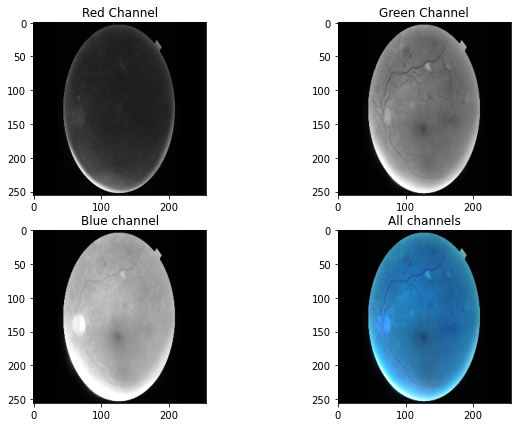

In [16]:
r = img1[:,:,0]
g = img1[...,1]
b = img1[...,2]

fig = plt.figure(figsize=(10,7))
fig.add_subplot(2, 2, 1)
plt.imshow(r, cmap=plt.cm.gray)
plt.title("Red Channel")
fig.add_subplot(2, 2, 2)
plt.imshow(g, cmap=plt.cm.gray)
plt.title("Green Channel")
fig.add_subplot(2, 2, 3)
plt.imshow(b, cmap=plt.cm.gray)
plt.title("Blue channel")
fig.add_subplot(2, 2, 4)
plt.imshow(img1, cmap=plt.cm.gray)
plt.title("All channels")


## ANN

In [17]:
print(dftrain.shape)
print(dftest.shape)
print(dfeval.shape)

(1920, 47)
(640, 47)
(640, 47)


In [18]:
def model1_preprocessImage(path, id):
    # print(path)
    img = cv2.imread(f'{path}/{id}.png')
    # print(np.amax(img))
    if(img is None):
        return np.zeros((32, 32))
    img = cv2.resize(img, (32, 32))
    R, G, B = cv2.split(img)
    output1_R = cv2.equalizeHist(R)
    output1_G = cv2.equalizeHist(G)
    output1_B = cv2.equalizeHist(B)
    img = cv2.merge((output1_R, output1_G, output1_B))
    img = rgb2gray(img)
    return img


In [19]:
model1_dftrain = dftrain
model1_dfeval = dfeval
model1_dftest = dftest

In [20]:
print(model1_dftrain.shape)
print(model1_dftest.shape)
print(model1_dfeval.shape)
print(model1_dftrain.shape)
print(model1_dftest.shape)
print(model1_dfeval.shape)


(1920, 47)
(640, 47)
(640, 47)
(1920, 47)
(640, 47)
(640, 47)


In [21]:
model1_dftrain['Image'] = model1_dftrain.ID.apply(
    lambda id: model1_preprocessImage(f'input/Training_Set/Training', id))
model1_dftest['Image'] = model1_dftest.ID.apply(lambda id: model1_preprocessImage(
    'input/Test_Set/Test_Set/Test', id))
model1_dfeval['Image'] = model1_dfeval.ID.apply(lambda id: model1_preprocessImage(
    'input/Evaluation_Set/Evaluation_Set/Validation', id))

In [22]:
print(model1_dftrain.shape)
print(model1_dftest.shape)
print(model1_dfeval.shape)
print(dftrain.shape)
print(dftest.shape)
print(dfeval.shape)


(1920, 48)
(640, 48)
(640, 48)
(1920, 48)
(640, 48)
(640, 48)


In [23]:
model1_trainimages = []
for i in range(0, 1920):
    model1_trainimages.append(np.array(model1_dftrain['Image'][i]).flatten())
    if(i % 500 == 0):
        print(i)
model1_trainimages = np.array(model1_trainimages)
print(model1_trainimages[0].shape)
model1_y = np.array(model1_dftrain.drop(['ID', 'Image'], axis=1))
print(model1_y.shape)


0
500
1000
1500
(1024,)
(1920, 46)


In [24]:
model1_evalimages = []
for i in range(0, 640):
    model1_evalimages.append(np.array(model1_dfeval['Image'][i]).flatten())
    if(i % 500 == 0):
        print(i)
model1_evalimages = np.array(model1_evalimages)
print(model1_evalimages[0].shape)
model1_yeval = np.array(model1_dfeval.drop(['ID', 'Image'], axis=1))
print(model1_yeval.shape)


0
500
(1024,)
(640, 46)


In [25]:
model1_testimages = []
for i in range(0, 640):
    model1_testimages.append(np.array(model1_dftest['Image'][i]).flatten())
    if(i % 500 == 0):
        print(i)
model1_testimages = np.array(model1_testimages)
print(model1_testimages[0].shape)
model1_ytest = np.array(model1_dftest.drop(['ID', 'Image'], axis=1))
print(model1_ytest.shape)


0
500
(1024,)
(640, 46)


In [26]:
model1 = Sequential()
model1.add(Dense(1024, input_shape=(None, 1024), activation="relu"))
model1.add(Dropout(0.5))
model1.add(Dense(512, activation='relu'))
model1.add(Dropout(0.5))
model1.add(Dense(46, activation='softmax'))
model1.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model1.summary()


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, None, 1024)        1049600   
_________________________________________________________________
dropout (Dropout)            (None, None, 1024)        0         
_________________________________________________________________
dense_1 (Dense)              (None, None, 512)         524800    
_________________________________________________________________
dropout_1 (Dropout)          (None, None, 512)         0         
_________________________________________________________________
dense_2 (Dense)              (None, None, 46)          23598     
Total params: 1,597,998
Trainable params: 1,597,998
Non-trainable params: 0
_________________________________________________________________


In [27]:
import warnings
warnings.filterwarnings("ignore")
model1.fit(model1_trainimages, model1_y, epochs=10, batch_size=1)

Epoch 1/10
1920/1920 [==============================] - 16s 4ms/step - loss: 0.1430 - accuracy: 0.9236
Epoch 2/10
1920/1920 [==============================] - 8s 4ms/step - loss: 0.0996 - accuracy: 1.0000
Epoch 3/10
1920/1920 [==============================] - 8s 4ms/step - loss: 0.0972 - accuracy: 1.0000
Epoch 4/10
1920/1920 [==============================] - 9s 5ms/step - loss: 0.0958 - accuracy: 1.0000
Epoch 5/10
1920/1920 [==============================] - 9s 5ms/step - loss: 0.0954 - accuracy: 1.0000
Epoch 6/10
1920/1920 [==============================] - 8s 4ms/step - loss: 0.0958 - accuracy: 1.0000
Epoch 7/10
1920/1920 [==============================] - 8s 4ms/step - loss: 0.0940 - accuracy: 1.0000
Epoch 8/10
1920/1920 [==============================] - 8s 4ms/step - loss: 0.0966 - accuracy: 1.0000
Epoch 9/10
1920/1920 [==============================] - 11s 6ms/step - loss: 0.0981 - accuracy: 1.0000
Epoch 10/10
1920/1920 [==============================] - 10s 5ms/step - loss: 0.

In [28]:
import warnings
warnings.filterwarnings("ignore")
model1.evaluate(model1_evalimages, model1_yeval, batch_size=1)

640/640 [==============================] - 2s 2ms/step - loss: 0.0988 - accuracy: 1.0000


[0.0988154485821724, 1.0]

In [29]:
import warnings
warnings.filterwarnings("ignore")
model1.evaluate(model1_testimages, model1_ytest, batch_size=1)


640/640 [==============================] - 1s 2ms/step - loss: 0.0947 - accuracy: 1.0000


[0.09472627937793732, 1.0]

## Feature Extraction + ML Models + Multilabel Classification

In [30]:
model_feat = keras.Model(inputs=model1.input, outputs=model1.get_layer('dense_2').output)
feat_train = model_feat.predict(model1_trainimages)
feat_eval = model_feat.predict(model1_evalimages)
feat_test = model_feat.predict(model1_testimages)
print(feat_train.shape)
print(feat_train[0].shape)
print(feat_eval.shape)
print(feat_eval[0].shape)

(1920, 46)
(46,)
(640, 46)
(46,)


## Binary relevance

### Binary relevance is simple each target variable(y1,y2, ..,yn) is treated independently and we are reduced to n classification problems. Scikit-Multilearn implements this for us, saving us the hassle of splitting the dataset and training each of them separately.This classifier can generalize beyond labels present in the training set. However it is very slow if the label space is large.

![image info](binary-relevance.jpg)


## LabelPowerSet

### This method transforms the problem into a multiclass classification problem; the target variables(y1,y2, ..,yn) are combined and each combination is treated as a unique class. This method will produce many classes.This transformation reduces the problem to only one classifier but, all possible labels need to be present in the training set.

![image info](label-powerset.jpg)

## ClassifierChain

### Classifier chains are akin to binary relevance, however the target variables (y1,y2, ..,yn) are not fully independent. The features (x1,x2,.., xm) are initially used to predict y1. Next (x1,x2,.., xm, y1) is used to predict y2. At the nth step, (x1,x2,..,xm,y1,..,yn−1) predicts yn. The ordering in which the labels are predicted can be determined by the user and can greatly influence the results.This classifier takes label dependencies into account and generalizes to label combinations not present in the training data. However the quality of the classifier is heavily dependent on the ordering; there are n!possible orderings and this method is slow if the label space is large.

![image info](chain-classifiers.jpg)

In [31]:
from sklearn.multiclass import OneVsRestClassifier
from sklearn.preprocessing import MultiLabelBinarizer

binarizer = MultiLabelBinarizer()
y_train_binarized = binarizer.fit_transform(model1_y)
y_test_binarized = binarizer.fit_transform(model1_ytest)
y_eval_binarized = binarizer.fit_transform(model1_yeval)


In [32]:
from sklearn.model_selection import GridSearchCV
from skmultilearn.adapt import MLkNN
import warnings
warnings.filterwarnings("ignore")

parameters = {'k': range(46, 47), 's': [0.5, 0.7, 1.0]}
score = 'f1_micro'


gscv_mlknn_classifier = GridSearchCV(MLkNN(), parameters, scoring=score)
gscv_mlknn_classifier.fit(feat_train, model1_y)
print('best parameters :', gscv_mlknn_classifier.best_params_, 'best score: ',
      gscv_mlknn_classifier.best_score_)
print(gscv_mlknn_classifier.score(feat_eval, model1_yeval))
print(gscv_mlknn_classifier.score(feat_test, model1_ytest))

best parameters : {'k': 46, 's': 0.5} best score:  0.5486543113488073
0.5502990755845568
0.5575757575757575


In [33]:
from sklearn.model_selection import GridSearchCV
from skmultilearn.adapt import MLkNN
import warnings
warnings.filterwarnings("ignore")

parameters = {'k': range(46, 47), 's': [0.5, 0.7, 1.0]}
score = 'f1_micro'


bgscv_mlknn_classifier = GridSearchCV(MLkNN(), parameters, scoring=score)
bgscv_mlknn_classifier.fit(feat_train, y_train_binarized)
print('best parameters :', bgscv_mlknn_classifier.best_params_, 'best score: ',
      bgscv_mlknn_classifier.best_score_)
print(bgscv_mlknn_classifier.score(feat_eval, y_eval_binarized))
print(bgscv_mlknn_classifier.score(feat_test, y_test_binarized))


best parameters : {'k': 46, 's': 0.5} best score:  0.9437759759096845
0.9447650453421269
0.9447650453421269


In [34]:
from sklearn.model_selection import GridSearchCV
from skmultilearn.adapt import BRkNNaClassifier
import warnings
warnings.filterwarnings("ignore")
parameters = {'k': range(46, 47)}
score = 'f1_micro'

gscv_brknn_classifier = GridSearchCV(BRkNNaClassifier(), parameters, scoring=score)
gscv_brknn_classifier.fit(feat_train, y_train_binarized)

print('best parameters :', gscv_brknn_classifier.best_params_,
      'best score: ', gscv_brknn_classifier.best_score_)
print(gscv_brknn_classifier.score(feat_eval, y_eval_binarized))
print(gscv_brknn_classifier.score(feat_test, y_eval_binarized))

best parameters : {'k': 46} best score:  0.9437759759096845
0.9447650453421269
0.9447650453421269


In [35]:
cls = OneVsRestClassifier(estimator=LogisticRegression())
cls.fit(feat_train, y_train_binarized)
print(cls.score(feat_train, y_train_binarized))
print(cls.score(feat_eval, y_eval_binarized))
print(cls.score(feat_test, y_test_binarized))


0.7911458333333333
0.790625
0.790625


In [36]:
parameters = [
    {
        'classifier': [MultinomialNB()]
    },
]

clf = GridSearchCV(ClassifierChain(), parameters)
clf.fit(feat_train, y_train_binarized)
print(clf.best_params_, clf.best_score_)
print(clf.score(feat_eval, y_eval_binarized))
print(clf.score(feat_test, y_test_binarized))


{'classifier': MultinomialNB()} 0.7911458333333333
0.790625
0.790625


In [37]:
parameters = [
    {
        'classifier': [GaussianNB()]
    },
]

clf = GridSearchCV(ClassifierChain(), parameters)
clf.fit(feat_train, y_train_binarized)
print(clf.best_params_, clf.best_score_)
print(clf.score(feat_eval, y_eval_binarized))
print(clf.score(feat_test, y_test_binarized))


{'classifier': GaussianNB()} 0.7557291666666666
0.7484375
0.7390625


In [38]:
parameters = [
    {
        'classifier': [GaussianNB()]
    },
]

clf = GridSearchCV(LabelPowerset(), parameters)
clf.fit(feat_train, y_train_binarized)
print(clf.best_params_, clf.best_score_)
print(clf.score(feat_eval, y_eval_binarized))
print(clf.score(feat_test, y_test_binarized))


{'classifier': GaussianNB()} 0.20885416666666665
0.209375
0.209375


In [39]:
parameters = [
    {
        'classifier': [RandomForestClassifier(n_estimators=100)]
    },
]
clf = GridSearchCV(LabelPowerset(), parameters)
clf.fit(feat_train, y_train_binarized)
print(clf.best_params_, clf.best_score_)
print(clf.score(feat_eval, y_eval_binarized))
print(clf.score(feat_test, y_test_binarized))


{'classifier': RandomForestClassifier()} 0.7911458333333333
0.790625
0.790625


In [40]:
parameters = [
    {
        'classifier': [DecisionTreeClassifier()]
    },
]

clf = GridSearchCV(BinaryRelevance(), parameters)
clf.fit(feat_train, y_train_binarized)
print(clf.best_params_, clf.best_score_)
print(clf.score(feat_eval, y_eval_binarized))
print(clf.score(feat_test, y_test_binarized))


{'classifier': DecisionTreeClassifier()} 0.7911458333333333
0.790625
0.790625


## CNN

In [42]:
%%time
def model2_preprocessImage(path,id):
    # print(path)
    img = cv2.imread(f'{path}/{id}.png')
    img = cv2.resize(img, (256, 256))
    # print(np.amax(img))
    if(img is None):
        print(id)
        return np.zeros((256,256))
    R, G, B = cv2.split(img)
    output1_R = cv2.equalizeHist(R)
    output1_G = cv2.equalizeHist(G)
    output1_B = cv2.equalizeHist(B)
    img = cv2.merge((output1_R, output1_G, output1_B))
    img = rgb2gray(img)
    return img


CPU times: user 9 µs, sys: 14 µs, total: 23 µs
Wall time: 16 µs


In [43]:
model2_dftrain = dftrain
model2_dfeval = dfeval
model2_dftest = dftest
model2_dftrain['Image'] = model2_dftrain.ID.apply(
    lambda id: model2_preprocessImage(f'input/Training_Set/Training',id))
model2_dftest['Image'] = model2_dftest.ID.apply(lambda id: model2_preprocessImage(
    'input/Test_Set/Test_Set/Test', id))
model2_dfeval['Image'] = model2_dfeval.ID.apply(lambda id: model2_preprocessImage(
    'input/Evaluation_Set/Evaluation_Set/Validation', id))


In [44]:
model2_y = np.array(model2_dftrain.drop(['ID', 'Image'], axis=1))
model2_y.shape

(1920, 46)

In [45]:
model2_trainimages = []
for i in range(0,1920):
    model2_trainimages.append(np.reshape(model2_dftrain['Image'][i], [256, 256, 1]))
    if(i%500==0):
        print(i)
model2_trainimages = np.array(model2_trainimages)


0
500
1000
1500


In [46]:
model2 = Sequential()
model2.add(Conv2D(filters=16, kernel_size=(5, 5), activation="relu", input_shape=(256, 256, 1)))
model2.add(MaxPooling2D(pool_size=(2, 2)))
model2.add(Dropout(0.25))
model2.add(Conv2D(filters=32, kernel_size=(5, 5), activation='relu'))
model2.add(MaxPooling2D(pool_size=(2, 2)))
model2.add(Dropout(0.25))
model2.add(Conv2D(filters=64, kernel_size=(5, 5), activation="relu"))
model2.add(MaxPooling2D(pool_size=(2, 2)))
model2.add(Dropout(0.25))
model2.add(Conv2D(filters=64, kernel_size=(5, 5), activation='relu'))
model2.add(MaxPooling2D(pool_size=(2, 2)))
model2.add(Dropout(0.25))
model2.add(Flatten())
model2.add(Dense(128, activation='relu'))
model2.add(Dropout(0.5))
model2.add(Dense(64, activation='relu'))
model2.add(Dropout(0.5))
model2.add(Dense(46, activation='sigmoid'))

In [47]:
print(model2.output_shape)
model2.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model2.summary()


(None, 46)
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 252, 252, 16)      416       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 126, 126, 16)      0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 126, 126, 16)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 122, 122, 32)      12832     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 61, 61, 32)        0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 61, 61, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 57, 57,

In [48]:
model2.fit(model2_trainimages, model2_y, epochs=10, batch_size=1)

Epoch 1/10
1920/1920 [==============================] - 124s 64ms/step - loss: 0.2058 - accuracy: 0.7850
Epoch 2/10
1920/1920 [==============================] - 107s 56ms/step - loss: 0.1079 - accuracy: 1.0000
Epoch 3/10
1920/1920 [==============================] - 112s 59ms/step - loss: 0.1012 - accuracy: 1.0000
Epoch 4/10
1920/1920 [==============================] - 120s 63ms/step - loss: 0.1005 - accuracy: 1.0000
Epoch 5/10
1920/1920 [==============================] - 148s 77ms/step - loss: 0.0992 - accuracy: 1.0000
Epoch 6/10
1920/1920 [==============================] - 145s 76ms/step - loss: 0.0984 - accuracy: 1.0000
Epoch 7/10
1920/1920 [==============================] - 136s 71ms/step - loss: 0.0979 - accuracy: 1.0000
Epoch 8/10
1920/1920 [==============================] - 149s 78ms/step - loss: 0.0952 - accuracy: 1.0000
Epoch 9/10
1920/1920 [==============================] - 150s 78ms/step - loss: 0.0989 - accuracy: 1.0000
Epoch 10/10
1920/1920 [==============================] 

In [49]:
model2_evalimages = []
for i in range(0, 640):
    model2_evalimages.append(np.reshape(model2_dfeval['Image'][i], [256, 256, 1]))
    if(i % 500 == 0):
        print(i)
model2_evalimages = np.array(model2_evalimages)
model2_yeval = np.array(model2_dfeval.drop(['ID', 'Image'], axis=1))
model2_yeval.shape

0
500


(640, 46)

In [50]:
model2_testimages = []
for i in range(0, 640):
    model2_testimages.append(np.reshape(model2_dftest['Image'][i], [256, 256, 1]))
    if(i % 500 == 0):
        print(i)
model2_testimages = np.array(model2_testimages)
model2_ytest = np.array(model2_dftest.drop(['ID', 'Image'], axis=1))
model2_ytest.shape

0
500


(640, 46)

In [51]:
model2.evaluate(model2_evalimages,model2_yeval,batch_size=1)


640/640 [==============================] - 6s 9ms/step - loss: 0.0992 - accuracy: 1.0000


[0.09916508942842484, 1.0]

In [52]:
model2.evaluate(model2_testimages, model2_yeval, batch_size=1)


640/640 [==============================] - 5s 8ms/step - loss: 0.0992 - accuracy: 1.0000


[0.09916508942842484, 1.0]